# Pet Data set examples

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import io
import os
import cv2 as cv
from PIL import Image
import PIL

The code below has ben taken from the Grad-CAM class activation visualization.

### Neural network

In [2]:
#Le modele que je vais utiliser
model_builder = keras.applications.xception.Xception

#La taille de l'image en entrée
img_size = (299, 299)

preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

#Pour récupérer le resultat de la detrnière couche du cnn
last_conv_layer_name = "block14_sepconv2_act"

### The Grad-CAM methods

In [3]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

### Example

This the image that we will use in our example

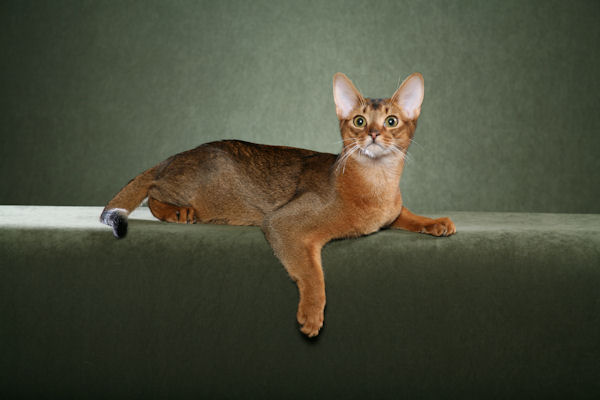

In [4]:
img_path = '../Images/EXP_DATA/Images/Abyssinian_1.jpg'

image = Image.open(img_path)

display(image)

### The saliency map

Predicted: [('n02124075', 'Egyptian_cat', 7.6348248)]


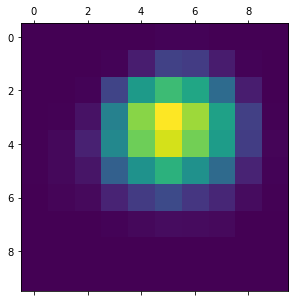

In [5]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

### Display the saliency map in the image

In [6]:
def display_gradcam(img_path, heatmap, alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    
    
    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
    

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    
    plt.imshow(superimposed_img)

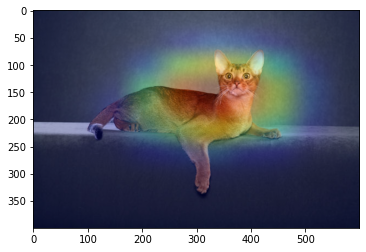

In [7]:
display_gradcam('../Images/EXP_DATA/Images/Abyssinian_1.jpg', heatmap)

### Saliency map evaluation

In this section we will evaluate the saliency maps produced by the GradCAM method.

In [8]:
import metrics
import metrics_utils as utils

First, we need resize the heat map.

In [9]:
image_dim = np.array(image).shape

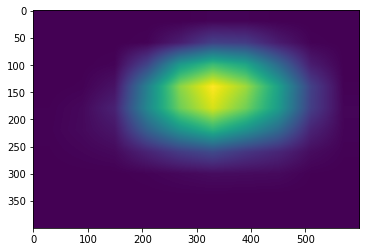

In [10]:
resized_heat_map = cv.resize(heatmap, dsize= (image_dim[1], image_dim[0]))
plt.imshow(resized_heat_map)

Then we need to threshold the heat map.

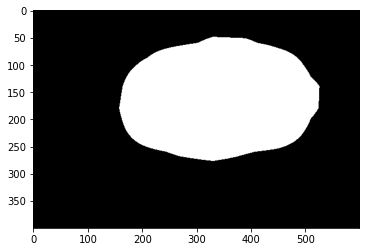

In [11]:
avearge_saliency = utils.get_average(resized_heat_map)
mask = utils.binarize(resized_heat_map, avearge_saliency)
plt.imshow(mask, "gray")

We need also the bounding boxes for our evaluations.

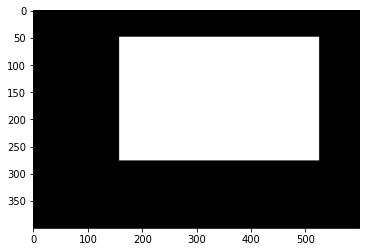

In [12]:
predicted_box = utils.make_matrix(mask, utils.get_bounding_box(mask))
plt.imshow(predicted_box, "gray")

In [13]:
trimap = utils.read_trimap("../Images/EXP_DATA/Masks/Abyssinian_1.png")
binary_map = utils.transform_trimap(trimap)
ground_truth_box = utils.make_matrix(binary_map, utils.get_bounding_box(binary_map))

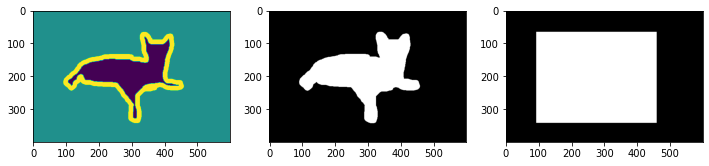

In [14]:
fig, ax = plt.subplots(1, 3, figsize = (12, 12))

ax[0].imshow(trimap)
ax[1].imshow(binary_map, "gray")
ax[2].imshow(ground_truth_box, "gray")

Now we can start our evaluations. First let's compute the localization error for both mask and box versions

In [15]:
metrics.LE(ground_truth_box, predicted_box)

0.3759625636772894

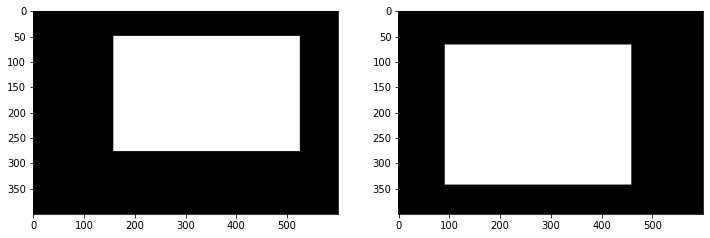

In [16]:
fig, ax = plt.subplots(1, 2, figsize = (12, 12))

ax[0].imshow(predicted_box, "gray")
ax[1].imshow(ground_truth_box, "gray")

In [17]:
metrics.LE(binary_map, mask)

0.15926177426395693

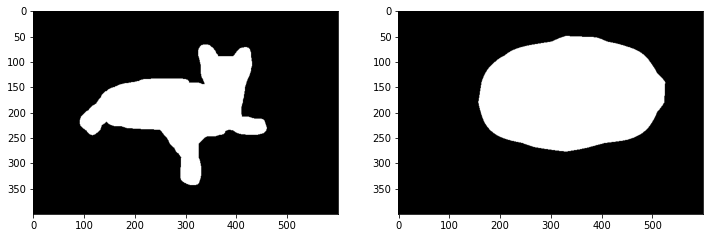

In [18]:
fig, ax = plt.subplots(1, 2, figsize = (12, 12))

ax[0].imshow(binary_map, "gray")
ax[1].imshow(mask, "gray")

### Dice coefficient

To calculate the error using the dice coefficient

In [19]:
1-metrics.DC(binary_map, mask)

0.34792953944831606

In [20]:
1-metrics.DC(ground_truth_box, predicted_box)

0.31517164045698565

### Energy pointing game

In [21]:
metrics.EPG(binary_map, resized_heat_map)

0.5916941758023682

In [22]:
metrics.EPG(ground_truth_box, resized_heat_map)

0.8755923253337113

### F-score

In [23]:
metrics.F_score(binary_map, mask)

0.6520704605516839

In [24]:
metrics.F_score(ground_truth_box, predicted_box)

0.6848283595430144

### Pixel-wise F-score

In [26]:
metrics.pixel_wise_F_score(binary_map, resized_heat_map)

0.5369834137764474

In [28]:
metrics.pixel_wise_F_score(ground_truth_box, resized_heat_map)

0.4425443626831729

### Average mean error

In [32]:
metrics.AME(resized_heat_map, ground_truth_box)

0.3148370770719919

In [33]:
metrics.AME(resized_heat_map, binary_map)

0.14563420798476137